In [3]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'svg'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import torch
import os
import numpy as np
from torchsummary import summary
from torchvision import transforms                                                                                                                                        
from torchvision import models
import matplotlib as mpl
import torchvision
mpl.rcParams['figure.dpi'] = 600
from PIL import Image
import PIL
import matplotlib.pyplot as plt
import pandas as pd
import numpy

import sys
sys.path.append("../../extra/pytorch-cnn-visualizations/src")
import deep_dream

sys.path.append("../../src/")
sys.path.append("../")
import model
from datasets import imagenet
from utils.function import recreate_image

from layer_activation_with_guided_backprop import GuidedBackprop
from misc_functions import save_gradient_images
from aux.utils import obtain_features_map, load_imgs, zscore, extract_valid
from aux.visualization import visualize_features_map
from aux.visualization import visualize_features_map_for_comparision
from utils.visualizations.visualize import concat_imgs, preprocess_arrays

# Model

In [19]:
# model
backbone = "vgg16"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = model.Network(backbone=backbone, num_classes=1000)
net.to(device)
# resume from model
resume = "037-0"
model_dir = "/home/lincolnzjx/Desktop/Interpretation/saved/models"
resume_exp = resume.split("-")[0]
resume_epoch = resume.split("-")[1]
print("Resume from model from exp: {} at epoch {}".format(resume_exp, resume_epoch))
resume_path = os.path.join(model_dir, str(resume_exp), str(resume_epoch))
ckpt = torch.load(resume_path, map_location=device)
net.load_state_dict(ckpt, strict=False) 

Entire model.
Resume from model from exp: 037 at epoch 0


<All keys matched successfully>

# GBP

In [16]:
def gbp(prep_img, pretrained_model, selected_layer, selected_filter):
#     mean = [0.485, 0.456, 0.406]
#     std = [0.229, 0.224, 0.225]
#     reverse_mean = [-0.485, -0.456, -0.406]
#     reverse_std = [1/0.229, 1/0.224, 1/0.225]
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
#     ori_image = np.expand_dims(ori, axis=0) / 255
#     images_zscore = zscore(ori_image.astype(np.float32), mean, std)
#     original_image = torch.FloatTensor(images_zscore).to(device)
#     prep_imgs = original_image
#     pretrained_model.eval()
    GBP = GuidedBackprop(pretrained_model) 

#     prep_img = prep_imgs
    prep_img.requires_grad_(True)
    guided_grads = GBP.generate_gradients(prep_img, None, selected_layer, selected_filter)
    return guided_grads

In [36]:
def main(selected_layer=None, selected_filter=None, class_index=None):
    num_class = 30
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    reverse_mean = [-0.485, -0.456, -0.406]
    reverse_std = [1/0.229, 1/0.224, 1/0.225]
    train_transform = transforms.Compose([                                                                                                                                
        transforms.Resize((224, 224), interpolation=Image.BILINEAR),                                                                                              
        transforms.ToTensor(),                                                                                                                                            
           ])         
    trainset = imagenet.ImageNet(root="/media/lincolnzjx/HardDisk/Datasets/", 
                                 is_train=True, transform=train_transform)
    trainset.set_data([class_index], num_class)
    imgs_path = []                                                                                                                                                            
    images = []
    labels = []
    for img, label, img_path in trainset:                                                                                                                                     
        images.append(img.unsqueeze(0))                                                                                                                                       
        labels.append(label)                                                                                                                                                  
        imgs_path.append(img_path)  
    
    dirs = "/home/lincolnzjx/Desktop/Interpretation/saved/generated/GBP/"
    dirs = os.path.join(dirs, str(class_index))
    
    # dir_name = "L{}F{}/standalize".format(selected_layer, selected_filter)
    # dir_name_fm = "L{}F{}/standalize_fm".format(selected_layer, selected_filter)
    # dir_name = "L{}F{}/standalize_nn".format(selected_layer, selected_filter)
    # dir_name_fm = "L{}F{}/standalize_nn_fm".format(selected_layer, selected_filter)
    # dir_name = "L{}F{}/scale_positive".format(selected_layer, selected_filter)
    # dir_name_fm = "L{}F{}/scale_positive_fm".format(selected_layer, selected_filter)
    dir_name = "L{}F{}/scale_total".format(selected_layer, selected_filter)
    dir_name_fm = "L{}F{}/scale_total_fm".format(selected_layer, selected_filter)
    
    dir_path = os.path.join(dirs, dir_name)
    dir_path_fm = os.path.join(dirs, dir_name_fm)
    
    os.makedirs(dir_path, exist_ok=True)
    os.makedirs(dir_path_fm, exist_ok=True)
    
    mean = torch.Tensor([0.485, 0.456, 0.406]).reshape(1,-1,1,1)
    std  = torch.Tensor([0.229, 0.224, 0.225]).reshape(1,-1,1,1)
    
    for img, img_path in zip(images, imgs_path):
        img = img[0].permute((1,2,0)).numpy()
        X = (torch.FloatTensor(img[numpy.newaxis].transpose([0,3,1,2])*1) - mean) / std
        name = img_path.split("/")[-1].split(".")[0]
        
        # Ori
        ori_activation_maps = net.get_activation_maps(X.cuda(), selected_layer)
        sel_feature_map = ori_activation_maps[0][0,selected_filter]
        min_val = sel_feature_map.min()
        max_val = sel_feature_map.max()
        sel_feature_map -= sel_feature_map.min()
        sel_feature_map /= sel_feature_map.max()
        ori_fm_path = os.path.join(dir_path_fm, "ori_" + name +".png")
        cm = plt.get_cmap("jet")
    #     cm(sel_feature_map).save(ori_fm_path)
        sel_feature_map = cm(sel_feature_map)
        sel_feature_map = (sel_feature_map[:, :, :3] * 255).astype(np.uint8)
        Image.fromarray(sel_feature_map).save(ori_fm_path)
        
        # GBP 
        pretrained_model = torchvision.models.vgg16(pretrained=True)
        guided_grads = gbp(X.clone().detach(), pretrained_model, selected_layer, selected_filter)
        path = os.path.join(dir_path, name+".png")
        fm_path = os.path.join(dir_path_fm, name+".png")
        
        # Standalize
        # relevance_img = standalize(R[0][0], X.numpy(), path)
        # fm = visualize_sel_fm(net, relevance_img.transpose(2,0,1), selected_layer, selected_filter, min_val, max_val)
        # fm = (255 * fm).astype(np.uint8)
        # Image.fromarray(fm).save(fm_path)
        
        # Standlize remove negative
        # relevance_img = standalize_remove_negative(R[0][0], X.numpy(), path)
        # fm = visualize_sel_fm(net, relevance_img.transpose(2,0,1), selected_layer, selected_filter, min_val, max_val)
        # fm = (255 * fm).astype(np.uint8)
        # Image.fromarray(fm).save(fm_path)
        
        # Scale positive
        # relevance_img = scale_positive(R[0][0], X.numpy(), path)
        # fm = visualize_sel_fm(net, relevance_img.transpose(2,0,1), selected_layer, selected_filter, min_val, max_val)
        # fm = (255 * fm).astype(np.uint8)
        # Image.fromarray(fm).save(fm_path)
        
        # Scale total
        relevance_img = scale_total(guided_grads, X.numpy()[0], path)
        fm = visualize_sel_fm(net, relevance_img, selected_layer, selected_filter, min_val, max_val)
        fm = (255 * fm).astype(np.uint8)
        Image.fromarray(fm).save(fm_path)

In [7]:
# ori = Image.open("/media/lincolnzjx/HardDisk/Datasets/ilsvrc2012/train/n07747607/n07747607_10061.JPEG").resize((224, 224))
# images[0].shape
# len(images)

In [8]:
# mean = torch.Tensor([0.485, 0.456, 0.406]).reshape(1,-1,1,1)
# std  = torch.Tensor([0.229, 0.224, 0.225]).reshape(1,-1,1,1)
# img = images[0]
# img = img[0].permute((1,2,0)).numpy()
# X = (torch.FloatTensor(img[numpy.newaxis].transpose([0,3,1,2])*1) - mean) / std

In [9]:
# fm = visualize_sel_fm(net, X[0], selected_layer, selected_filter, min_val, max_val)
# print(fm.max(), fm.min())
# plt.imshow(fm)

# Visualization

In [10]:
def visualize_sel_fm(net, relevance_img, selected_layer, selected_filter, min_val, max_val): 
    cm = plt.get_cmap("jet")
    opt_activation_maps = net.get_activation_maps(torch.FloatTensor(relevance_img).unsqueeze(dim=0).cuda(), selected_layer)
    opt_sel_feature_map = opt_activation_maps[0][0,selected_filter]
    print(opt_sel_feature_map.max(), opt_sel_feature_map.min())
    opt_sel_feature_map -= min_val
    opt_sel_feature_map = np.maximum(0, opt_sel_feature_map)
    opt_sel_feature_map /= opt_sel_feature_map.max()
    opt_sel_feature_map = np.minimum(1, opt_sel_feature_map)
    print(opt_sel_feature_map.max())
    opt_sel_feature_map = cm(opt_sel_feature_map)
    return opt_sel_feature_map

## Scale max

## Standarization

1.291374 -1.211569
255 0


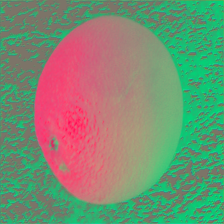

In [22]:
relevance = np.array(guided_grads)
normalized_img = images_zscore[0]
relevance_img = relevance * normalized_img
new_image = recreate_image(relevance_img, reverse_mean, reverse_std)
print(relevance.max(), relevance.min())
print(new_image.max(), new_image.min())
Image.fromarray(new_image)

In [32]:
def scale_max(relevance, normalized, path=None):
    reverse_mean = [-0.485, -0.456, -0.406]
    reverse_std = [1/0.229, 1/0.224, 1/0.225]
    
    relevance = np.array(relevance)
    relevance /= (np.abs(relevance)).max()
    relevance_img = normalized * relevance
    new_image = recreate_image(relevance_img, reverse_mean, reverse_std)
    print(new_image.max(), new_image.min())
    Image.fromarray(new_image).save(path)
    return relevance_img

## Scale total with zero

In [50]:
def scale_total_with_zero(relevance, normalized, path=None):
    reverse_mean = [-0.485, -0.456, -0.406]
    reverse_std = [1/0.229, 1/0.224, 1/0.225]
    
    relevance = np.array(relevance)
#     relevance_img = normalized * (relevance * relevance==0)
    relevance -= relevance.min()
    relevance /= relevance.max()
    relevance_img = relevance_img * relevance
    
    new_image = recreate_image(relevance_img, reverse_mean, reverse_std)
#     print(new_image.max(), new_image.min())
    Image.fromarray(new_image).save(path)
    return relevance_img

## Scale total

In [34]:
def scale_total(relevance, normalized, path=None):
    reverse_mean = [-0.485, -0.456, -0.406]
    reverse_std = [1/0.229, 1/0.224, 1/0.225]
    
    relevance = np.array(relevance)
    relevance /= np.max(np.abs(relevance))
    relevance_img = normalized * relevance
#     relevance -= relevance.min()
#     relevance /= relevance.max()
    new_image = recreate_image(relevance_img, reverse_mean, reverse_std)
    Image.fromarray(new_image).save(path)
    return relevance_img

# Main

In [37]:
selected = [
    [1, 47],
    [1, 16],
    [3, 20],
    [6, 19],
    [8, 99],
    [11, 75],
    [15, 173],
    [18, 49],
    [22, 485],
    [25, 1],
    [29, 334]
]
class_indexes = [14, 950, 522]

for class_index in class_indexes:
    for selected_layer, selected_filter in selected:
        if selected_filter == 1 and class_index == 522:
            print(class_index, selected_layer, selected_filter)
            main(selected_layer, selected_filter, class_index)

522 25 1
Len of new dataset is :30
(3, 224, 224)
(3, 224, 224)
4.4542994 0.0
1.0
(3, 224, 224)
(3, 224, 224)
1.8613948 0.0
1.0
(3, 224, 224)
(3, 224, 224)
6.370195 0.0
1.0
(3, 224, 224)
(3, 224, 224)
9.538648 0.0
1.0
(3, 224, 224)
(3, 224, 224)
7.373114 0.0
1.0
(3, 224, 224)
(3, 224, 224)
2.6801505 0.0
1.0
(3, 224, 224)
(3, 224, 224)
4.0099554 0.0
1.0
(3, 224, 224)
(3, 224, 224)
4.0124393 0.0
1.0
(3, 224, 224)
(3, 224, 224)
17.83246 0.0
1.0
(3, 224, 224)
(3, 224, 224)
1.6338317 0.0
1.0
(3, 224, 224)
(3, 224, 224)
5.572253 0.0
1.0
(3, 224, 224)
(3, 224, 224)
1.7871947 0.0
1.0
(3, 224, 224)
(3, 224, 224)
4.918175 0.0
1.0
(3, 224, 224)
(3, 224, 224)
2.65786 0.0
1.0
(3, 224, 224)
(3, 224, 224)
7.6333222 0.0
1.0
(3, 224, 224)
(3, 224, 224)
2.0077078 0.0
1.0
(3, 224, 224)
(3, 224, 224)
14.614128 0.0
1.0
(3, 224, 224)
(3, 224, 224)
2.2865949 0.0
1.0
(3, 224, 224)
(3, 224, 224)
11.32246 0.0
1.0
(3, 224, 224)
(3, 224, 224)
5.8002906 0.0
1.0
(3, 224, 224)
(3, 224, 224)
6.6363044 0.0
1.0
(3, 224,

min, max 0.0 32.192833
3.2151427 0.0
1.0


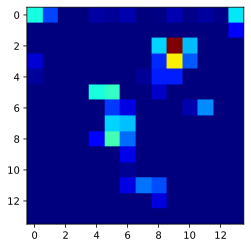

In [149]:
selected_layer = 25
selected_filter = 1

# ori = Image.open("/media/lincolnzjx/HardDisk/Datasets/ilsvrc2012/train/n07747607/n07747607_10061.JPEG").resize((224, 224))

# ori = Image.open("/media/lincolnzjx/HardDisk/Datasets/ilsvrc2012/train/n07747607/n07747607_10110.JPEG").resize((224, 224))
# ori = Image.open("/media/lincolnzjx/HardDisk/Datasets/ilsvrc2012/train/n07747607/n07747607_10166.JPEG").resize((224, 224))
# ori = Image.open("/media/lincolnzjx/HardDisk/Datasets/ilsvrc2012/train/n07747607/n07747607_10205.JPEG").resize((224, 224))
# ori = Image.open("/media/lincolnzjx/HardDisk/Datasets/ilsvrc2012/train/n07747607/n07747607_10465.JPEG").resize((224, 224))

# ori = Image.open("/media/lincolnzjx/HardDisk/Datasets/ilsvrc2012/train/n03134739/n03134739_10258.JPEG").resize((224, 224))
ori = Image.open("/media/lincolnzjx/HardDisk/Datasets/ilsvrc2012/train/n03134739/n03134739_10193.JPEG").resize((224, 224))

cm = plt.get_cmap("jet")
ori_arr = np.array(ori)/255
ori_nor = (torch.FloatTensor(ori_arr[numpy.newaxis].transpose([0,3,1,2])*1) - mean) / std
ori_activation_maps = net.get_activation_maps(ori_nor.cuda(), selected_layer)
sel_feature_map = ori_activation_maps[0][0,selected_filter]
min_val = sel_feature_map.min()
sel_feature_map -= min_val
max_val = sel_feature_map.max()
sel_feature_map /= max_val
# plt.imshow(cm(sel_feature_map))
print("min, max" ,min_val, max_val)

# img = Image.open("/home/lincolnzjx/Desktop/Interpretation/saved/pack/7009/149999/n07747607_10061.png").resize((224, 224))
# img = Image.open("/home/lincolnzjx/Desktop/Interpretation/saved/pack/060490/116566/n07747607_10061.png").resize((224, 224))

# img = Image.open("/home/lincolnzjx/Desktop/Interpretation/saved/pack/060490/116566/n07747607_10166.png").resize((224, 224))
# img = Image.open("/home/lincolnzjx/Desktop/Interpretation/saved/pack/060490/116566/n07747607_10110.png").resize((224, 224))
# img = Image.open("/home/lincolnzjx/Desktop/Interpretation/saved/pack/060490/116566/n07747607_10061.png").resize((224, 224))
# img = Image.open("/home/lincolnzjx/Desktop/Interpretation/saved/pack/060490/116566/n07747607_10166.png").resize((224, 224))
# img = Image.open("/home/lincolnzjx/Desktop/Interpretation/saved/pack/060490/116566/n07747607_10465.png").resize((224, 224))

# img = Image.open("/home/lincolnzjx/Desktop/Interpretation/saved/generated/deconv_baseline/scale_0_15_173.png").resize((224, 224))
# img = Image.open("/home/lincolnzjx/Desktop/Interpretation/saved/generated/deconv_baseline/scale_0_3_20.png").resize((224, 224))
# img = Image.open("/home/lincolnzjx/Desktop/Interpretation/saved/generated/deconv_baseline/scale_2_3_20.png").resize((224, 224))
# img = Image.open("/home/lincolnzjx/Desktop/Interpretation/saved/generated/deconv_baseline/scale_11_3_20.png").resize((224, 224))
# img = Image.open("/home/lincolnzjx/Desktop/Interpretation/saved/generated/deconv_baseline/scale_25_3_20.png").resize((224, 224))
# img = Image.open("/home/lincolnzjx/Desktop/Interpretation/saved/generated/deconv_baseline/scale_0_3_20.png").resize((224, 224))
# img = Image.open("/home/lincolnzjx/Desktop/Interpretation/saved/generated/deconv_baseline/scale_0_3_20.png").resize((224, 224))

# img = Image.open("/home/lincolnzjx/Desktop/Interpretation/saved/pack/9008/200000/n03134739_10258.png").resize((224, 224))
img = Image.open("/home/lincolnzjx/Desktop/Interpretation/saved/pack/9008/200000/n03134739_10193.png").resize((224, 224))

img = np.array(img) / 255
X = (torch.FloatTensor(img[numpy.newaxis].transpose([0,3,1,2])*1) - mean) / std
fm = visualize_sel_fm(net, X[0], selected_layer, selected_filter, min_val, max_val)
plt.imshow(fm)
# img

In [143]:
ori_arr

array([[[0.14509804, 0.15686275, 0.17647059],
        [0.21568627, 0.22745098, 0.24705882],
        [0.38431373, 0.39607843, 0.41568627],
        ...,
        [0.73333333, 0.7254902 , 0.76862745],
        [0.78039216, 0.77254902, 0.81568627],
        [0.80784314, 0.8       , 0.84313725]],

       [[0.18431373, 0.19607843, 0.21568627],
        [0.24705882, 0.25882353, 0.27843137],
        [0.40392157, 0.41568627, 0.43529412],
        ...,
        [0.76078431, 0.75294118, 0.79607843],
        [0.77647059, 0.76862745, 0.81176471],
        [0.75294118, 0.74509804, 0.78823529]],

       [[0.23921569, 0.25098039, 0.27058824],
        [0.28235294, 0.29411765, 0.31372549],
        [0.42352941, 0.43529412, 0.45490196],
        ...,
        [0.74509804, 0.7372549 , 0.78039216],
        [0.79607843, 0.78823529, 0.83137255],
        [0.78431373, 0.77647059, 0.81960784]],

       ...,

       [[0.2745098 , 0.29019608, 0.30196078],
        [0.26666667, 0.28235294, 0.29411765],
        [0.2745098 , 0

In [38]:
net

Network(
  (model): VGG16(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      (16)